In [177]:
import numpy as np
import skimage.io as skio
import skimage.morphology as skm
import skimage.measure as skme
import skimage.exposure as ske
import matplotlib.pyplot as plt
import scipy as sci
import cv2
import datetime as dt
import matplotlib.dates as md

In [176]:
def get_time(frames, fps):
    """
    function that displays the current time of the video based on the frame number.
    frames: frame number of a video
    fps: frames per second of the video
    """
    if frames == 0:
        return ("00:00:00")
    else:
        seconds = (frames//fps)
        minutes = seconds // 60
        hours = minutes // 60
        
        seconds = seconds % 60
        minutes = minutes % 60
        hours = hours % 60
        
        if seconds < 10:
            seconds = "0" + str(seconds)
        if minutes < 10:
            minutes = "0" + str(minutes)
        if hours < 10:
            hours = "0" + str(hours)
        
        time = (str(hours) + ":" + str(minutes) + ":" + str(seconds))
        return time

print(get_time(3000, 30))

00:01:40


In [156]:
def get_blobs_from_video(videoname, filename, filemode):
    """
    videoname: a video name in the format of a string (ex: "monday 11am.MP4")
    filename: a textfile to write the data to
    filemode: append or write ('a+' or 'w+')
    """
    cap = cv2.VideoCapture(videoname) #define video here
    fgbg = cv2.createBackgroundSubtractorKNN(detectShadows=False)
    fr = 0

    width = int(cap.get(3)) #openCV's method of getting width from a video
    height = int(cap.get(4)) #openCV's method of getting height from a video
    frames_per_second = round(cap.get(cv2.CAP_PROP_FPS))

    FPS = frames_per_second #frames per second of video
    LINE_START = 150 #where we determine the line to start for our algorithm
    IMG_WIDTH = width #width of video
    IMG_HEIGHT = height #height of video
    FR_SKIP = 1800 #how many frames we wish to skip (30 frames = 1 second)
    MIN_BLOB = 20000 #minimum blob size to be considered a significant portion of the line that is disconnected (~ 2 people)

    blobsizes = []
    framenum = []
    timestamps = []
    linelength = []

    kernel3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3)) #structuring element
    kernel6 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6,6)) #structuring element
    kernel10 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,3)) #structuring element
    kernel9 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9)) #structuring element

    frlength = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) #the number of frames to be processed in the video

    f = open(filename, filemode)

    print("Number of frames in this video: ", frlength)
    print("reading...")

    while fr < (frlength - FR_SKIP): #(fr < 40000):

        if fr % FR_SKIP == 0: #at FR_SKIP frames, skip every x frames (x frames per second)
            cap.set(cv2.CAP_PROP_POS_FRAMES,fr);
            ret, frame = cap.read()
            fgmask = fgbg.apply(frame)

            fgmask[475:720] = 0 #cut out the bottom half of the video and turn it black!
            fgmask[:175] = 0 #cut a top portion of the video and turn it black

            median = sci.ndimage.median_filter(fgmask, 4) #remove salt&pepper type noise
            # Remove noise
            opening = cv2.morphologyEx(median, cv2.MORPH_OPEN, kernel9) #aggressively remove noise with opening!
            # Dilate to merge adjacent blobs
            dilation = cv2.dilate(opening, kernel10, iterations=5)
            # Fill any small holes
            finalblob = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, kernel9) #the last major morphological step, 
                                                                             #call it finalblob
            areaMax = 0
            c = None
            labels = skme.label(finalblob)        
            regions = skme.regionprops(labels)
            for p in regions:
                if p.area > areaMax:
                    areaMax = p.area
                    (min_row, min_col, max_row, max_col) = p.bbox #we want the leftmost x-coordinate of the blob

            #do a second runthrough, check if there are significantly sized blobs, add those 
            #larger than a certain threshold MIN_BLOB to the largest area
            for q in regions: 
                if q.area > MIN_BLOB and q.area != areaMax:
                    areaMax += q.area
                    (min_row2, min_col2, max_row2, max_col2) = q.bbox
                    if min_col2 < 100:
                        min_col = min_col2
                    if max_col2 > max_col:
                        max_col = max_col2

            if min_col > LINE_START: #if the line is formed beyond 100 pixels of the left side of the screen,
                                     #don't call that a line!
                areaMax = 0
            linelength.append(max_col - min_col) #append line lengths (in relation to the width of IMG_WIDTH)
            blobsizes.append(areaMax) #append blob sizes to a list
            framenum.append(fr//30)
            lineThickness = 2

            #draw a line depicting where the algorithm sees the start of the line
            cv2.line(finalblob, (LINE_START, 100), (LINE_START, IMG_HEIGHT), (100,0,0), lineThickness)

            #draw a rectangle around the largest blob
            cv2.rectangle(finalblob,(min_col, min_row),(max_col, max_row), (200,200,200), lineThickness)

            frame = cv2.resize(frame, (640, 480))   # Resize image
            blobs = cv2.resize(finalblob, (640, 480))  # Resize image
            cv2.imshow('fgmask', blobs)
            cv2.imshow('frame', frame)
            time = get_time(fr, FPS)
            timestamps.append(time)
            print("time: " , time , " area: " , areaMax) #"frame count: ", fr)

        fr += FR_SKIP
        k = cv2.waitKey(1) & 0xff #don't set the waitkey to 0, but lower the count if you want the frames to flow faster
        if k == 27: #press escape key to exit windows
            break

    for blobs in blobsizes:
        f.write(str(blobs) + "\n")  

    print("Done!")
    cap.release()
    cv2.destroyAllWindows()

    f.close()


In [165]:
get_blobs_from_video("monday 12pm.MP4", "monday.txt", "r+") #need videos to make this work! 

Number of frames in this video:  107595
reading...
time:  00:00:00  area:  398080
time:  00:01:00  area:  398080
time:  00:02:00  area:  398014
time:  00:03:00  area:  397555
time:  00:04:00  area:  161327
time:  00:05:00  area:  0
time:  00:06:00  area:  0
time:  00:07:00  area:  0
time:  00:08:00  area:  0
time:  00:09:00  area:  6916
time:  00:10:00  area:  0
time:  00:11:00  area:  0
time:  00:12:00  area:  24985
time:  00:13:00  area:  25608
time:  00:14:00  area:  0
time:  00:15:00  area:  0
time:  00:16:00  area:  0
time:  00:17:00  area:  176492
time:  00:18:00  area:  77395
time:  00:19:00  area:  144772
time:  00:20:00  area:  154860
time:  00:21:00  area:  133613
time:  00:22:00  area:  179763
time:  00:23:00  area:  148987
time:  00:24:00  area:  131121
time:  00:25:00  area:  122161
time:  00:26:00  area:  111868
time:  00:27:00  area:  119637
time:  00:28:00  area:  138407
time:  00:29:00  area:  82910
time:  00:30:00  area:  0
time:  00:31:00  area:  11652
time:  00:32:0

In [102]:
def read_data(filename):
    """
    reads the blob data from a file.
    filename: filename ("monday.txt", "tuesday.txt", etc.)
    """
    f = open(filename, "r")
    blobs = f.read()
    bloblist = blobs.split("\n")
    for i in range(len(bloblist)):
        if bloblist[i] == "":
            bloblist[i] = 0
        bloblist[i] = int(bloblist[i])
    f.close()
    return bloblist

In [138]:
def create_times(days, hours, minutes):
    """
    create datetime objects for the graphs below. We can assume the month and year since our data
    was only created during November 2018.
    day: the day of the month
    hours: the hour the video was created
    minutes: the minute the video was created
    """
    times = []
    years = 2018
    months = 11

    for i in range(len(bloblist)):
        time = dt.datetime(year=years, month=months, day=days, hour=hours,minute=(minutes%60))
        minutes+=1
        if minutes%60 == 0:
            hours+=1
        time = md.date2num(time)
        times.append(time)
    return times

In [170]:
def process_data(blobdata):
    """
    processes the blob data by applying a median filter across our list, removing bad data spikes, and
    removing abnormally large blobs.
    blobdata: a list of integers that corresponds to the blobdata
    """
    #apply median filter of size 3 to our bloblist (as suggested by professor Vaccari)
    mblobs = sci.ndimage.median_filter(blobdata, 5) #gaussian filter (as suggested by professor Vaccari)
    mblobs = sci.ndimage.filters.gaussian_filter1d(mblobs, 3)
    #we want to get rid of the abnormally large blob sizes that exist at the beginning of our background subtraction
    count = 0
    cap = len(mblobs)
    for blob in mblobs:
        #attempt to get rid of bad data spikes
        if count < cap-1 and mblobs[count - 1] < 80000 and mblobs[count + 1] < 80000 and blob > 300000:
            mblobs[count] = 0
        if blob > 345000: #if the blob is unreasonably large, make it equivalent to the previous value
            mblobs[count] = mblobs[count-1]
        count+=1
    return mblobs

Video metadata (date created) for create_times() function:

Monday 11/5 start time: 10:53:12 am

Tuesday 11/6 start time: 11:11:31 am

Wednesday 11/7 start time: 10:53:12 am

Thursday 11/8 start time: 10:51:13 am

Friday 11/9 start time: 11:34:14 am

In [173]:
bloblist = read_data("wednesday.txt")
mblobs = process_data(bloblist)
print(mblobs)
times = create_times(5, 10, 53) #REMEMBER TO CHANGE THESE PARAMETERS when switching text files! (day, hour, minute)

[144882 144882 144882 144882 144882 340138 316684 290378 262931 236063
 211114 188812 169279 152221 137211 123919 112212 102097  93578  86518
  80606  75439  70672  66135  61908  58315  55871  55174  56732  60774
  67121  75193  84174  93257 101816 109413 115677 120161 122360 121881
 118721 113460 107267 101674  98207  98022 101652 108982 119387 132024
 146115 161143 176933 193627 211595 231253 252759 275642 298517 319159
 334999 343880 344700 337632 323849 304981 282619 258125 232712 207608
 184086 163274 145877 131999 121157 112510 105132  98256  91412  84447
  77469  70714  64429  58808  53987  50087  47217  45420  44595  44433
  44454  44126  43041  41060  38362  35369  32610  30569  29599  29897
  31521  34405  38391  43260  48791  54811  61213  67906  74798  81864
  89326  97888 108840 123872 144495 171191 202606 235244 263972 283302
 289014 279449 256024 222816 185471 149804 120507 100281  89613  87169
  90634  97662 106619 116878 128644 142451 158555 176557 195351 213433
 22934

<IPython.core.display.Javascript object>


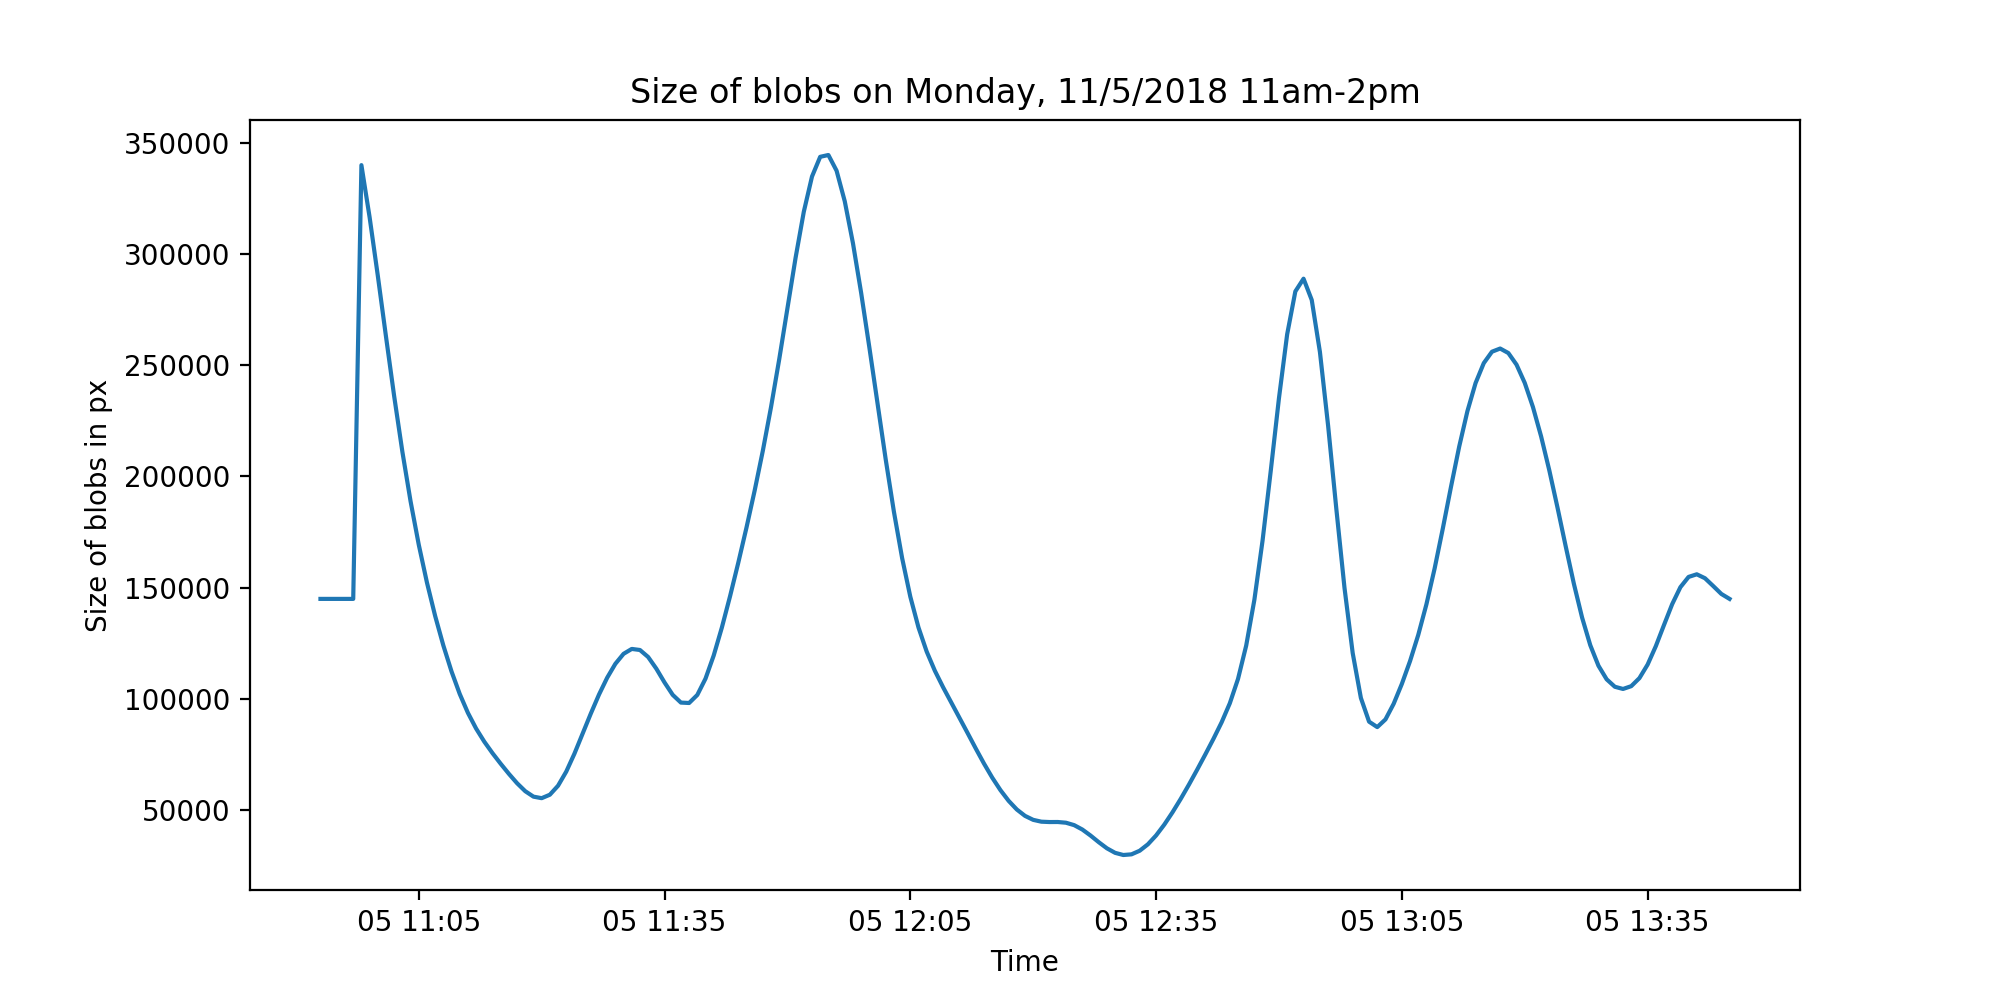

Text(0.5,1,'Size of blobs on Monday, 11/5/2018 11am-2pm')

In [178]:
%matplotlib notebook

plt.figure(figsize=(10,5))
plt.plot_date(times, mblobs, fmt="-")
plt.xlabel("Time")
plt.ylabel("Size of blobs in px")
plt.title("Size of blobs on Monday, 11/5/2018 11am-2pm") #change the day to reflect the data's date

In [121]:
%matplotlib inline